In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
df = pd.read_csv("BTC-USD.csv")

In [3]:
# lets base this on open
# TODO fix this later
def prepare_data(dataset):
    dataset = df[['Date', 'Open']]
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    
    # Sort the dataset by date
    dataset.sort_values('Date', inplace=True, ignore_index=True)
    
    # I need to understand the scaler function in a bit
    # for now, let me have a model to work off of
    
    # Scale the "opening_price" values
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset['Open'] = scaler.fit_transform(dataset['Open'].values.reshape(-1, 1))
    
    return dataset
'''TODO: Create an error of null values
given_data_set = prepare_data(df)
given_data_set.loc[given_data_set['Open'].isnull()]
'''
# discover why this has a nan

"TODO: Create an error of null values\ngiven_data_set = prepare_data(df)\ngiven_data_set.loc[given_data_set['Open'].isnull()]\n"

In [5]:
given_data_set = df
# x data is dataset from 0:60
# y data is the 61st,

def create_sequences(data, seq_length):
    x = []
    y = []
    
    for i in range(0, len(data) - seq_length):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    
    return np.array(x), np.array(y)

seq_length = 60
X, y = create_sequences(given_data_set[['Open']].values, seq_length)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

type(X)


numpy.ndarray

In [7]:
# Auto Encoder

#Encoder part
latent_dim = 10  # You can choose the latent dimension based on your dataset

model = Sequential()

# Encoder
model.add(LSTM(latent_dim, activation='relu', input_shape=(X.shape[1], 1)))

# Encoded vector
model.add(RepeatVector(X.shape[1]))


# Decoder
model.add(LSTM(latent_dim, activation='relu', return_sequences=True))

# Reconstruction of the original input
model.add(TimeDistributed(Dense(1)))


model.compile(optimizer="Adam", loss='mean_squared_error')


In [8]:
# What does epochs mean? and what does it mean by batch size?
model.fit(X, X, epochs=10, batch_size=32)


Epoch 1/10
96/96 [==============================] - 3s 16ms/step - loss: 0.0249
Epoch 2/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0080
Epoch 3/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0062
Epoch 4/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0052
Epoch 5/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0046
Epoch 6/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0041
Epoch 7/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0037
Epoch 8/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0034
Epoch 9/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0028
Epoch 10/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0026


In [9]:
# find otu why its producing NAN
encoder = Sequential(model.layers[:2])
encoded_data = encoder.predict(X)

encoded_data

96/96 [==============================] - 0s 3ms/step


array([[[5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00],
        [5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00],
        [5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00],
        ...,
        [5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00],
        [5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00],
        [5.3706012e-06, 0.0000000e+00, 7.4721038e-02, ...,
         9.5840156e-01, 0.0000000e+00, 2.3062675e+00]],

       [[5.3714230e-06, 0.0000000e+00, 7.4692212e-02, ...,
         9.5842868e-01, 0.0000000e+00, 2.3066821e+00],
        [5.3714230e-06, 0.0000000e+00, 7.4692212e-02, ...,
         9.5842868e-01, 0.0000000e+00, 2.3066821e+00],
        [5.3714230e-06, 0.0000000e+00, 7.4692212e-02, ...,
         9.584

In [10]:
"""# Encode the input data
encoder = Sequential(model.layers[:2])
encoded_data = encoder.predict(X)

# Decode the encoded data
decoder = Sequential(model.layers[2:])
decoded_data = decoder.predict(encoded_data)
"""
#Somewhere here, the data became nan

encoder = Sequential(model.layers[:2])
encoded_data = encoder.predict(X)

# take the encoded data an prep it for the LSTM

X_encoded, y_encoded = create_sequences(encoded_data, seq_length)

X_encoded.shape, encoded_data.shape
# Reshape the data for the LSTM model
X_encoded = np.reshape(X_encoded, (X_encoded.shape[0], X_encoded.shape[1], encoded_data.shape[2]))

96/96 [==============================] - 0s 2ms/step


In [11]:

predictor_model = Sequential()
predictor_model.add(LSTM(50, return_sequences=True, input_shape=(X_encoded.shape[1], X_encoded.shape[2])))
predictor_model.add(Dropout(0.2))
predictor_model.add(LSTM(50, return_sequences=True))
predictor_model.add(Dropout(0.2))
predictor_model.add(LSTM(50))
predictor_model.add(Dropout(0.2))
predictor_model.add(Dense(1))

predictor_model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
predictor_model.fit(X_encoded, y_encoded, epochs=10, batch_size=32)

Epoch 1/10
94/94 [==============================] - 3s 37ms/step - loss: 0.2677
Epoch 2/10
94/94 [==============================] - 3s 37ms/step - loss: 0.2675
Epoch 3/10
94/94 [==============================] - 4s 40ms/step - loss: 0.2675
Epoch 4/10
94/94 [==============================] - 4s 38ms/step - loss: 0.2674
Epoch 5/10
94/94 [==============================] - 4s 38ms/step - loss: 0.2673
Epoch 6/10
94/94 [==============================] - 4s 38ms/step - loss: 0.2672
Epoch 7/10
94/94 [==============================] - 4s 38ms/step - loss: 0.2672
Epoch 8/10
94/94 [==============================] - 4s 44ms/step - loss: 0.2672
Epoch 9/10
94/94 [==============================] - 4s 40ms/step - loss: 0.2671
Epoch 10/10
94/94 [==============================] - 4s 40ms/step - loss: 0.2671


In [50]:
# predict the encoded data
predicted_encoded_data = predictor_model.predict(X_encoded)

# decode the data
decoder = Sequential(model.layers[2:])
decoded_data = decoder.predict(encoded_data)



#next_day_predicted_price =  decoder.predict(encoded_data[decoded_data[0]-1])

# make a graph for this

96/96 [==============================] - 0s 2ms/step


array([[ 0.00650504],
       [-0.02251741],
       [-0.01371075],
       [-0.00541466],
       [-0.0064563 ],
       [-0.00837027],
       [-0.00916851],
       [-0.00876819],
       [-0.00758769],
       [-0.00604437],
       [-0.0044276 ],
       [-0.00290333],
       [-0.00154977],
       [-0.00039144],
       [ 0.0005763 ],
       [ 0.00137188],
       [ 0.00201885],
       [ 0.0025409 ],
       [ 0.00296031],
       [ 0.00329579],
       [ 0.00356357],
       [ 0.0037768 ],
       [ 0.00394659],
       [ 0.00408153],
       [ 0.00418873],
       [ 0.00427385],
       [ 0.00434144],
       [ 0.00439502],
       [ 0.00443764],
       [ 0.00447138],
       [ 0.00449829],
       [ 0.00451951],
       [ 0.00453632],
       [ 0.0045497 ],
       [ 0.00456031],
       [ 0.00456874],
       [ 0.00457545],
       [ 0.00458078],
       [ 0.00458489],
       [ 0.00458826],
       [ 0.00459088],
       [ 0.004593  ],
       [ 0.00459467],
       [ 0.00459604],
       [ 0.00459702],
       [ 0

In [58]:

next_day_value = decoded_data[-1, -1, 0]
decoded_data.shape, next_day_value

((3067, 60, 1), 0.3713225)

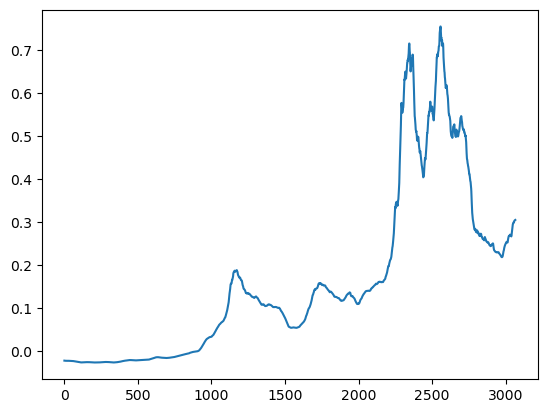

In [43]:
# LSTM in an LSTM model
import matplotlib.pylab as plt

x = np.arange(0, 3067)
new_decoded_data = np.reshape(decoded_data, (3067, 60))
y = df_decoded_data.loc[:,1]


# normalize the other one.

# grab first row


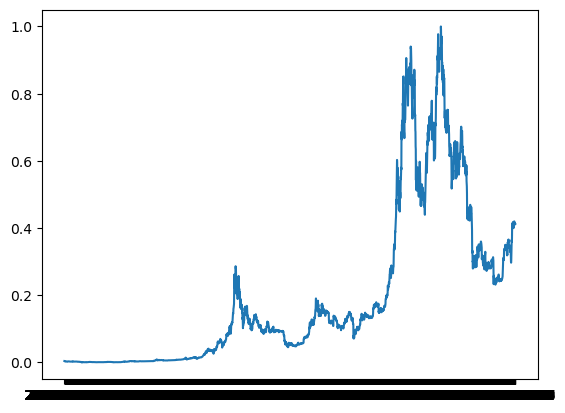

In [46]:
test_df = df
scaler = MinMaxScaler(feature_range=(0, 1))
test_df['Open'] = scaler.fit_transform(test_df['Open'].values.reshape(-1, 1))



ValueError: x and y must have same first dimension, but have shapes (3067,) and (3127,)

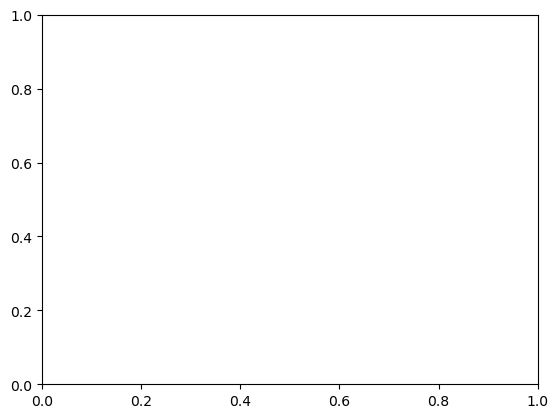

In [47]:
# have it create the next prediction 
# this is good, now time to refactor everything else

old_x = test_df['Date']
old_y = test_df['Open']

plt.plot(x, old_y)

In [ ]:
# create a function that will predict the next value of the day

#prediction first, then autoencode
#ASFvbo VIFVNFVWESUIFJK:VBFVWEFGVFVWSWEF

